# リポジトリ クローン

In [1]:
!git clone https://github.com/carolineec/informative-drawings
%cd informative-drawings

Cloning into 'informative-drawings'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 101 (delta 21), reused 14 (delta 13), pack-reused 73
Receiving objects: 100% (101/101), 3.86 MiB | 2.57 MiB/s, done.
Resolving deltas: 100% (39/39), done.
/content/informative-drawings


# 訓練済みモデル ダウンロード

In [2]:
# checkpointsディレクトリ生成
!mkdir checkpoints

In [3]:
# Googleドライブからモデルをダウンロード
!gdown 'https://drive.google.com/uc?id=11l5u5sb1PO5Z5YA3IoEHauVPm0k407C1'

Downloading...
From: https://drive.google.com/uc?id=11l5u5sb1PO5Z5YA3IoEHauVPm0k407C1
To: /content/informative-drawings/model.zip
100% 47.7M/47.7M [00:00<00:00, 169MB/s]


In [4]:
# 解凍
!unzip model.zip -d checkpoints

Archive:  model.zip
   creating: checkpoints/model/
   creating: checkpoints/model/contour_style/
  inflating: checkpoints/model/contour_style/netG_A_latest.pth  
   creating: checkpoints/model/opensketch_style/
  inflating: checkpoints/model/opensketch_style/.DS_Store  
  inflating: checkpoints/model/opensketch_style/netG_A_latest.pth  
   creating: checkpoints/model/anime_style/
  inflating: checkpoints/model/anime_style/netG_A_latest.pth  


# モデルロード(Anime Style)

In [5]:
# モデル入力画像の一辺のサイズ
input_size = 512

In [6]:
# ドットアクセス用の辞書クラス
class DictDotNotation(dict): 
    def __init__(self, *args, **kwargs): 
        super().__init__(*args, **kwargs) 
        self.__dict__ = self 

In [7]:
# 疑似的なコマンドライン引数生成
opt = DictDotNotation()

opt.name = 'model/anime_style'
opt.dataroot = 'examples/test'
opt.checkpoints_dir = 'checkpoints'
opt.results_dir = 'results'
opt.geom_name = 'feats2Geom'
opt.batchSize = 1
opt.depthroot = ''
opt.input_nc = 3
opt.output_nc = 1
opt.geom_nc = 3
opt.every_feat = 1
opt.num_classes = 55
opt.midas = 0
opt.ngf = 64
opt.n_blocks = 3
opt.size = input_size
opt.cuda = True
opt.n_cpu = 8
opt.which_epoch = 'latest'
opt.aspect_ratio = 1.0
opt.mode = 'test'
opt.load_size = input_size
opt.crop_size = input_size
opt.max_dataset_size = float("inf")
opt.preprocess = 'resize_and_crop'
opt.no_flip = False
opt.norm = 'instance'
opt.predict_depth = 0
opt.save_input = 0
opt.reconstruct = 0
opt.how_many = 100

print(opt)

{'name': 'model/anime_style', 'dataroot': 'examples/test', 'checkpoints_dir': 'checkpoints', 'results_dir': 'results', 'geom_name': 'feats2Geom', 'batchSize': 1, 'depthroot': '', 'input_nc': 3, 'output_nc': 1, 'geom_nc': 3, 'every_feat': 1, 'num_classes': 55, 'midas': 0, 'ngf': 64, 'n_blocks': 3, 'size': 512, 'cuda': True, 'n_cpu': 8, 'which_epoch': 'latest', 'aspect_ratio': 1.0, 'mode': 'test', 'load_size': 512, 'crop_size': 512, 'max_dataset_size': inf, 'preprocess': 'resize_and_crop', 'no_flip': False, 'norm': 'instance', 'predict_depth': 0, 'save_input': 0, 'reconstruct': 0, 'how_many': 100}


In [8]:
import os

import torch
from model import Generator

# ネットワーク生成
net_G = Generator(opt.input_nc, opt.output_nc, opt.n_blocks)

# 重みをロード
net_G.load_state_dict(torch.load(os.path.join(opt.checkpoints_dir, opt.name, 'netG_A_%s.pth' % opt.which_epoch)))
device = 'cpu'
net_G.eval().to(device)

print('Loaded：', os.path.join(opt.checkpoints_dir, opt.name, 'netG_A_%s.pth' % opt.which_epoch))

Loaded： checkpoints/model/anime_style/netG_A_latest.pth


# ONNX変換(Anime Style)

In [9]:
def convert_to_onnx(net, file_name='output.onnx', input_shape=(512, 512), device='cpu'):
    input = torch.randn(1, 3, input_shape[0], input_shape[1]).to(device)

    input_layer_names = ['input_image']
    output_layer_names = ['output_image']

    torch.onnx.export(
        net, 
        input, 
        file_name, 
        verbose=True,
        opset_version=11,
        input_names=input_layer_names,
        output_names=output_layer_names,
    )

In [10]:
# ONNX変換
convert_to_onnx(net_G, 'anime_style_512x512.onnx', (input_size, input_size), device)

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:1159: UserWarning: ONNX export mode is set to inference mode, but operator instance_norm is set to training  mode. The operators will be exported in training , as specified by the functional operator.
  + ", as specified by the functional operator."


# 推論テスト

In [11]:
!pip install onnxruntime imread_from_url==0.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 20.2 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
  Created wheel for imread-from-url: filename=imread_from_url-0.1.2-py3-none-any.whl size=6564 sha256=267e0c7fe2daa159c6bc8d3e588484fb419ecb2d31fe50f5b35ff819bb827166
  Stored in directory: /root/.cache/pip/wheels/10/c4/e7/f5517a33d5b3bd6e32bba66ec56c2183037510439325a029d5
Successfully built imread-from-url


In [12]:
from imread_from_url import imread_from_url

# サンプル画像ロード
image = imread_from_url('https://raw.githubusercontent.com/Kazuhito00/AnimeGANv2-ONNX-Sample/main/sample.jpg')

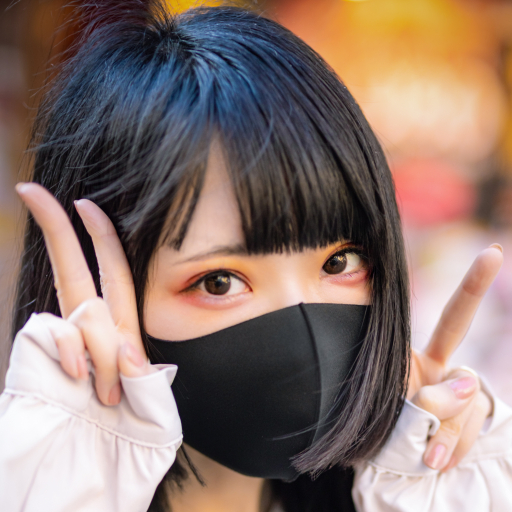

In [13]:
from google.colab.patches import cv2_imshow

# サンプル画像表示
cv2_imshow(image)

In [14]:
import onnxruntime

# ONNXモデルロード
onnx_session = onnxruntime.InferenceSession(
    'anime_style_512x512.onnx',
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider'],
)

input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

/usr/local/lib/python3.7/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:56: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  "Available providers: '{}'".format(name, ", ".join(available_provider_names))


In [15]:
import cv2 as cv
import numpy as np

# 前処理
image = cv.resize(image, dsize=(input_size, input_size))
x = cv.cvtColor(image, cv.COLOR_BGR2RGB)

x = np.array(x, dtype=np.float32)
x = x.transpose(2, 0, 1)
x = x.reshape(-1, 3, input_size, input_size)

# 推論
onnx_result = onnx_session.run([output_name], {input_name: x})

# 後処理
onnx_result = np.array(onnx_result).squeeze()
onnx_result = onnx_result * 255
onnx_result = onnx_result.astype(np.uint8)

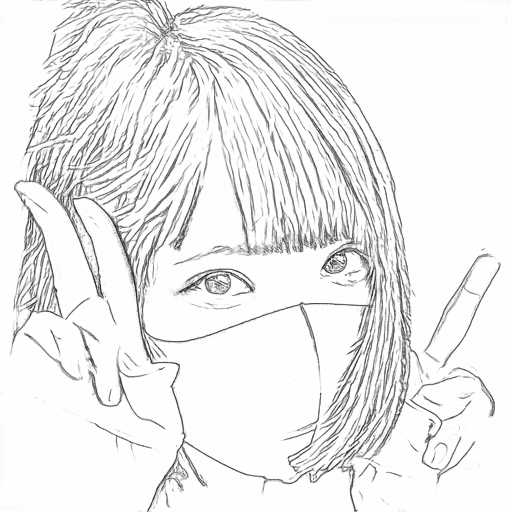

In [16]:
cv2_imshow(onnx_result)

# モデルロード(OpencSketch Style)

In [17]:
# 疑似的なコマンドライン引数生成
opt.name = 'model/opensketch_style'

print(opt)

{'name': 'model/opensketch_style', 'dataroot': 'examples/test', 'checkpoints_dir': 'checkpoints', 'results_dir': 'results', 'geom_name': 'feats2Geom', 'batchSize': 1, 'depthroot': '', 'input_nc': 3, 'output_nc': 1, 'geom_nc': 3, 'every_feat': 1, 'num_classes': 55, 'midas': 0, 'ngf': 64, 'n_blocks': 3, 'size': 512, 'cuda': True, 'n_cpu': 8, 'which_epoch': 'latest', 'aspect_ratio': 1.0, 'mode': 'test', 'load_size': 512, 'crop_size': 512, 'max_dataset_size': inf, 'preprocess': 'resize_and_crop', 'no_flip': False, 'norm': 'instance', 'predict_depth': 0, 'save_input': 0, 'reconstruct': 0, 'how_many': 100}


In [18]:
import torch
from model import Generator

# ネットワーク生成
net_G = Generator(opt.input_nc, opt.output_nc, opt.n_blocks)

# 重みをロード
net_G.load_state_dict(torch.load(os.path.join(opt.checkpoints_dir, opt.name, 'netG_A_%s.pth' % opt.which_epoch)))
device = 'cpu'
net_G.eval().to(device)

print('Loaded：', os.path.join(opt.checkpoints_dir, opt.name, 'netG_A_%s.pth' % opt.which_epoch))

Loaded： checkpoints/model/opensketch_style/netG_A_latest.pth


# ONNX変換(OpencSketch Style)

In [19]:
# ONNX変換
convert_to_onnx(net_G, 'opensketch_style_512x512.onnx', (input_size, input_size), device)

# 推論テスト

In [20]:
from imread_from_url import imread_from_url

# サンプル画像ロード
image = imread_from_url('https://raw.githubusercontent.com/Kazuhito00/AnimeGANv2-ONNX-Sample/main/sample.jpg')

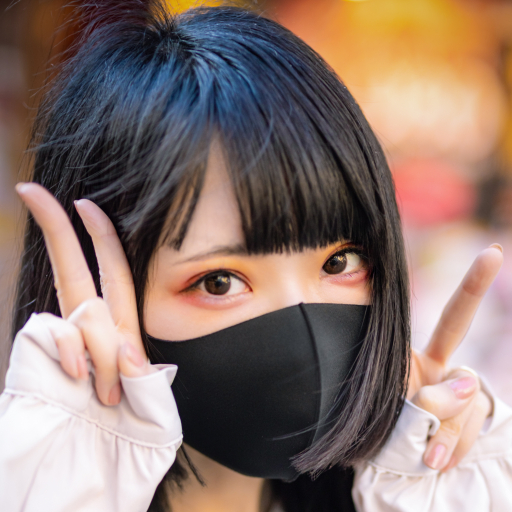

In [21]:
from google.colab.patches import cv2_imshow

# サンプル画像表示
cv2_imshow(image)

In [22]:
import onnxruntime

# ONNXモデルロード
onnx_session = onnxruntime.InferenceSession(
    'opensketch_style_512x512.onnx',
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider'],
)

input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

In [23]:
import cv2 as cv
import numpy as np

# 前処理
image = cv.resize(image, dsize=(input_size, input_size))
x = cv.cvtColor(image, cv.COLOR_BGR2RGB)

x = np.array(x, dtype=np.float32)
x = x.transpose(2, 0, 1)
x = x.reshape(-1, 3, input_size, input_size)

# 推論
onnx_result = onnx_session.run([output_name], {input_name: x})

# 後処理
onnx_result = np.array(onnx_result).squeeze()
onnx_result = onnx_result * 255
onnx_result = onnx_result.astype(np.uint8)

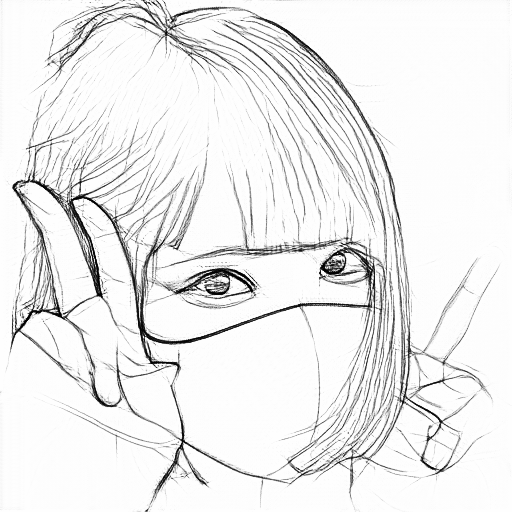

In [24]:
cv2_imshow(onnx_result)

# モデルロード(Contour Style)

In [25]:
# 疑似的なコマンドライン引数生成
opt.name = 'model/contour_style'

print(opt)

{'name': 'model/contour_style', 'dataroot': 'examples/test', 'checkpoints_dir': 'checkpoints', 'results_dir': 'results', 'geom_name': 'feats2Geom', 'batchSize': 1, 'depthroot': '', 'input_nc': 3, 'output_nc': 1, 'geom_nc': 3, 'every_feat': 1, 'num_classes': 55, 'midas': 0, 'ngf': 64, 'n_blocks': 3, 'size': 512, 'cuda': True, 'n_cpu': 8, 'which_epoch': 'latest', 'aspect_ratio': 1.0, 'mode': 'test', 'load_size': 512, 'crop_size': 512, 'max_dataset_size': inf, 'preprocess': 'resize_and_crop', 'no_flip': False, 'norm': 'instance', 'predict_depth': 0, 'save_input': 0, 'reconstruct': 0, 'how_many': 100}


In [26]:
import torch
from model import Generator

# ネットワーク生成
net_G = Generator(opt.input_nc, opt.output_nc, opt.n_blocks)

# 重みをロード
net_G.load_state_dict(torch.load(os.path.join(opt.checkpoints_dir, opt.name, 'netG_A_%s.pth' % opt.which_epoch)))
device = 'cpu'
net_G.eval().to(device)

print('Loaded：', os.path.join(opt.checkpoints_dir, opt.name, 'netG_A_%s.pth' % opt.which_epoch))

Loaded： checkpoints/model/contour_style/netG_A_latest.pth


# ONNX変換(Contour Style)

In [27]:
# ONNX変換
convert_to_onnx(net_G, 'contour_style_512x512.onnx', (input_size, input_size), device)

# 推論テスト

In [28]:
from imread_from_url import imread_from_url

# サンプル画像ロード
image = imread_from_url('https://raw.githubusercontent.com/Kazuhito00/AnimeGANv2-ONNX-Sample/main/sample.jpg')

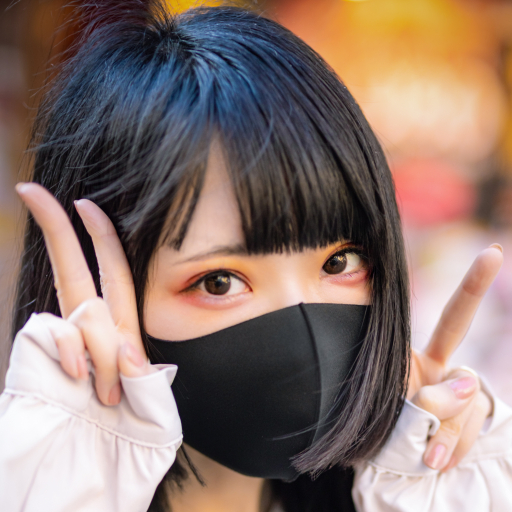

In [29]:
from google.colab.patches import cv2_imshow

# サンプル画像表示
cv2_imshow(image)

In [30]:
import onnxruntime

# ONNXモデルロード
onnx_session = onnxruntime.InferenceSession(
    'contour_style_512x512.onnx',
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider'],
)

input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

In [31]:
import cv2 as cv
import numpy as np

# 前処理
image = cv.resize(image, dsize=(input_size, input_size))
x = cv.cvtColor(image, cv.COLOR_BGR2RGB)

x = np.array(x, dtype=np.float32)
x = x.transpose(2, 0, 1)
x = x.reshape(-1, 3, input_size, input_size)

# 推論
onnx_result = onnx_session.run([output_name], {input_name: x})

# 後処理
onnx_result = np.array(onnx_result).squeeze()
onnx_result = onnx_result * 255
onnx_result = onnx_result.astype(np.uint8)

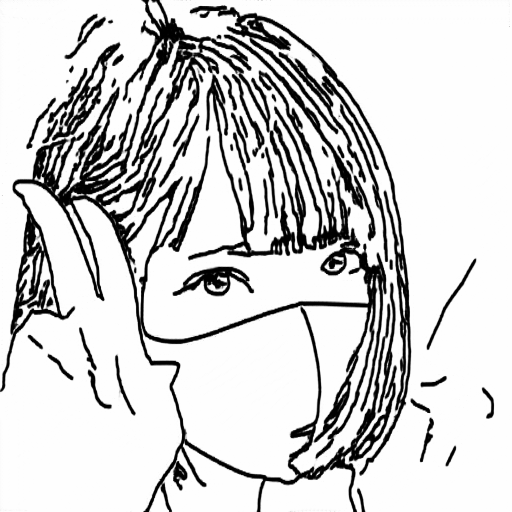

In [32]:
cv2_imshow(onnx_result)